# Data Processing
by Martha Burket (burke781@umn.edu), Carson DeSotel (desot033@umn.edu)  

GEOG 5543  
Fall 2021

## Preparation
The following code cells are used in the preparation of the Notebook. Ensure that you have all needed libraries installed and that all libraries / modules are imported before attempting to run any of the other cells. 

In [1]:
'''
    Installation:
'''
import sys
from IPython.utils import io

print('Installing Needed Libraries...')
with io.capture_output() as captured:
    !{sys.executable} -m pip install matplotlib
    !{sys.executable} -m pip install requests
    !{sys.executable} -m pip install climata
    !{sys.executable} -m pip install pandas
print('Finished Installation...')

Installing Needed Libraries...
Finished Installation...


In [2]:
'''
    Imports:
'''
### Standard Data Processing Imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime

### Climata Imports
import climata
from climata.usgs import InstantValueIO

In [24]:
'''
    Declare Global Variables
'''
### Define Target Stream
_TARGET     = '05372995'

### Define NWIS Code for Streamflow & Precipitation data
_STREAMFLOW = '00060'

### Define 10 Year Range
date_ranges = [('2012-04-01', '2012-09-30'),
               ('2013-04-01', '2013-09-30'),
               ('2014-04-01', '2014-09-30'),
               ('2015-04-01', '2015-09-30'),
               ('2016-04-01', '2016-09-30'),
               ('2017-04-01', '2017-09-30'),
               ('2018-04-01', '2018-09-30'),
               ('2019-04-01', '2019-09-30'),
               ('2020-04-01', '2020-09-30'),
               ('2021-04-01', '2021-09-30'), ]

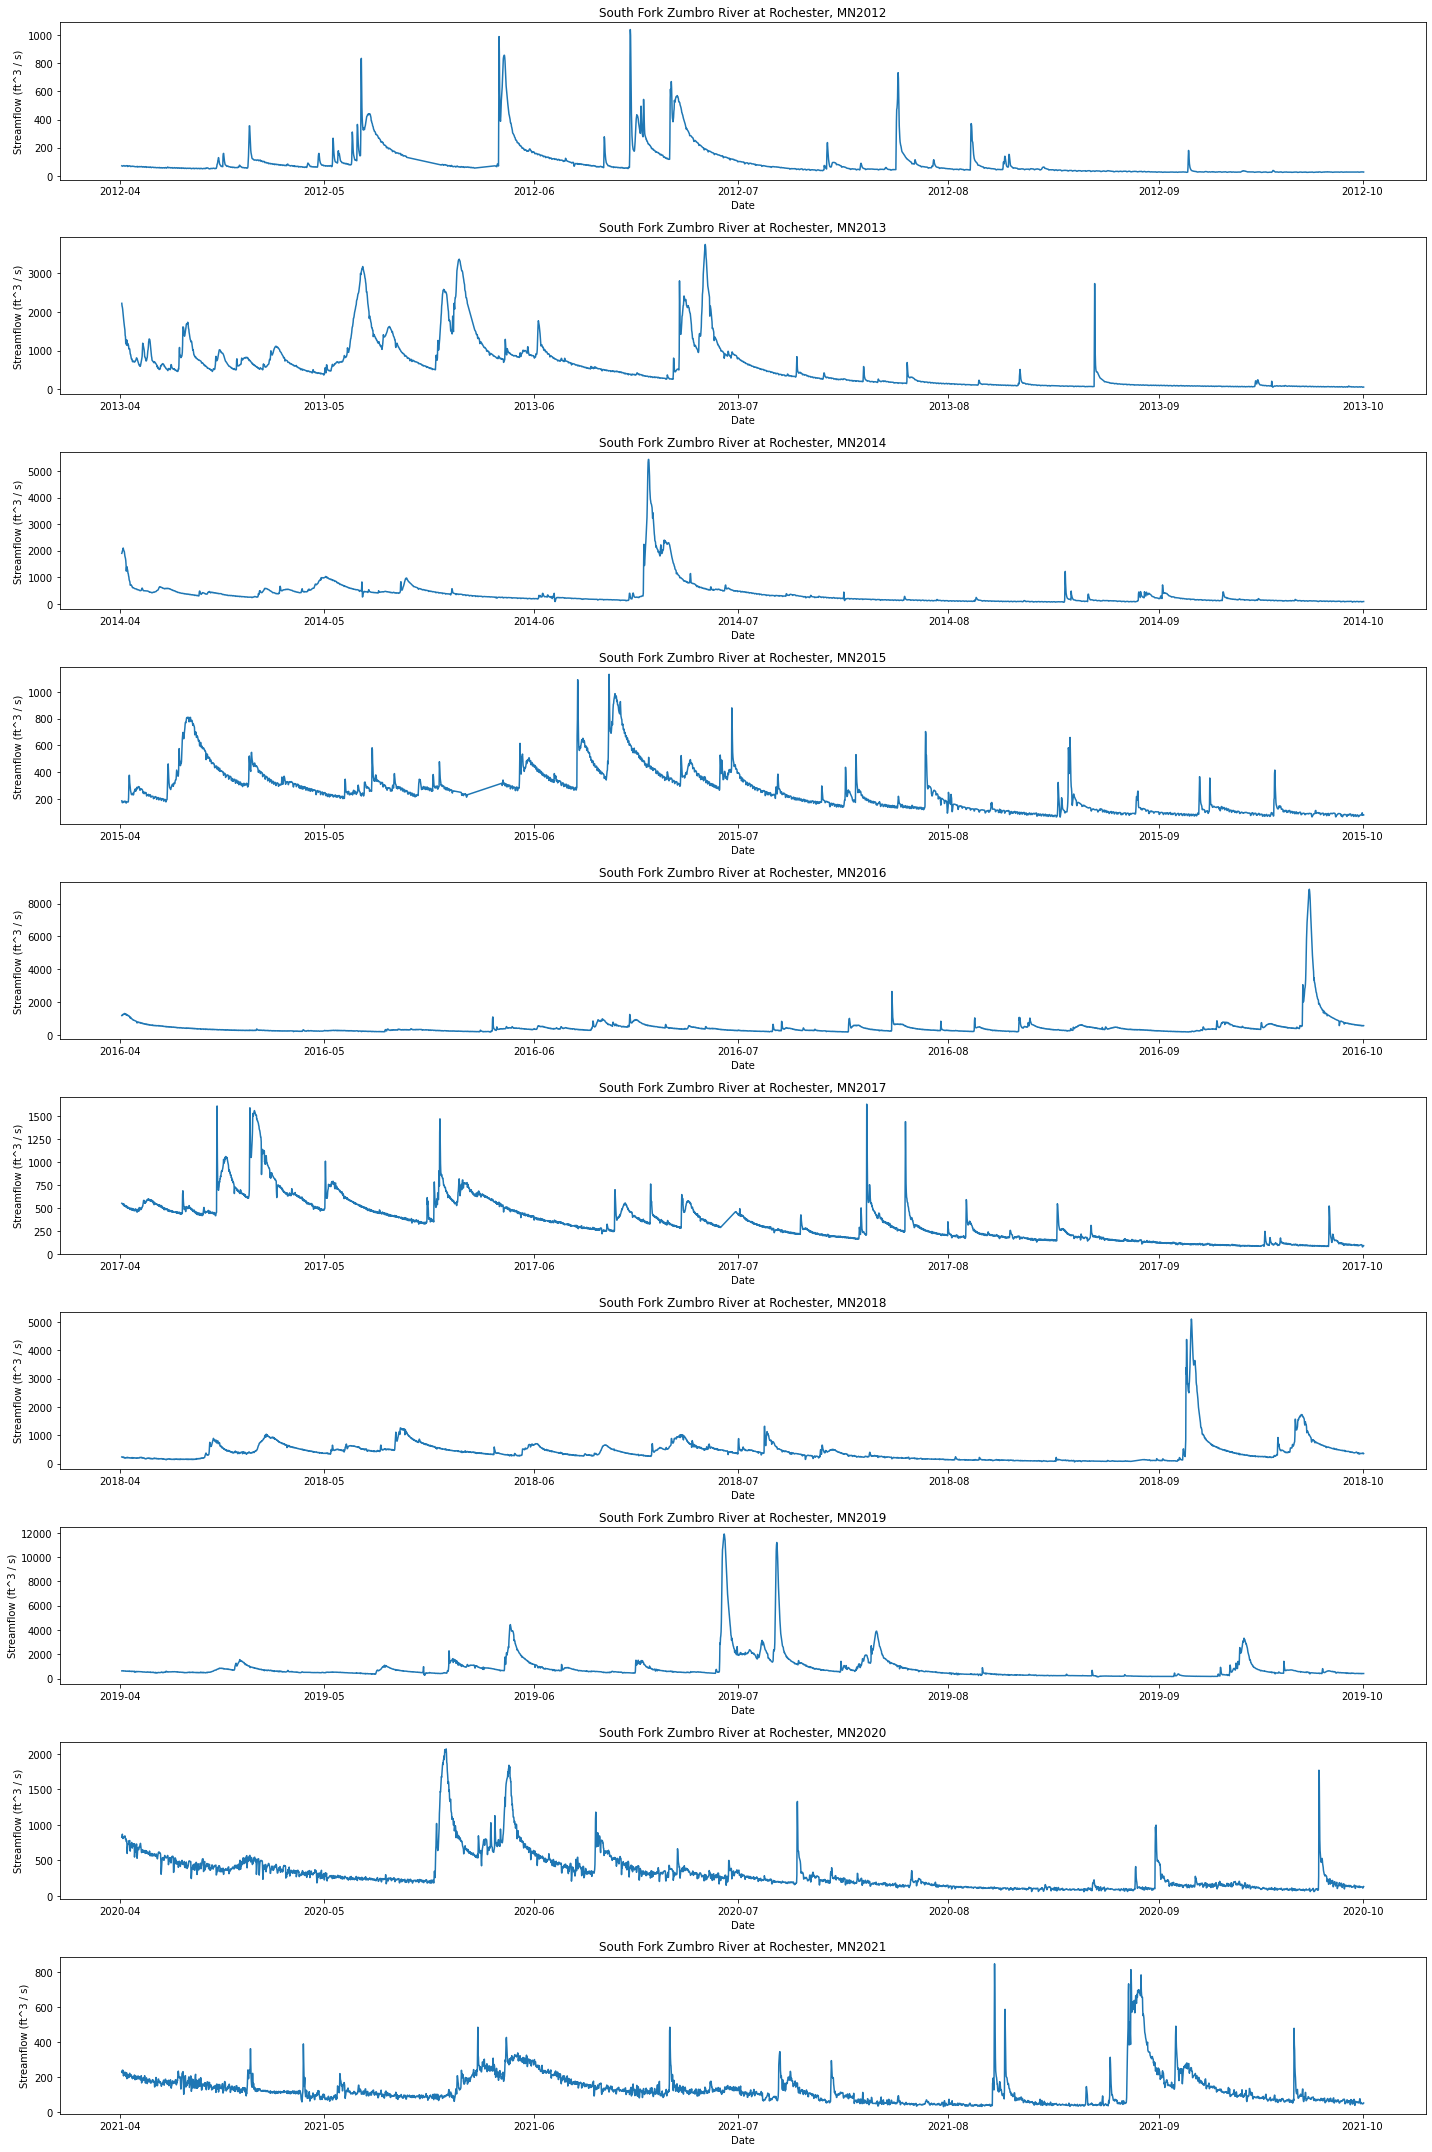

In [25]:
'''
    Extract time series streamflow data from the specified date ranges
    Visualize on separate charts
'''
### Define List of DataFrames
data_frames = []

### Prep plots
fig, axes = plt.subplots(nrows  = 10, 
                        ncols  = 1, 
                        figsize = (20, 30)) # width, height
ax = axes.ravel() # convert 2D to 1D array


index = 0 # set index counter
for date_range in date_ranges:
    ### Get Streamflow Data in date_range
    flow_data = InstantValueIO(
        start_date = date_range[0], # get starting date
        end_date   = date_range[1], # get ending date
        station    = _TARGET,       # get target stream     
        parameter  = _STREAMFLOW,   # plug in streamflow code (ft^3 / s)
    )
    
    ### Gather Flow Series data
    for flow_series in flow_data:
        flow    = [r[1] for r in flow_series.data]
        dates  = [r[0] for r in flow_series.data]
        
        ### Convert to Pandas Series Objects
        dates = pd.Series(pd.to_datetime(dates, utc = True))
        flow   = pd.Series(flow)

        ### Construct DataFrame from Pandas Series
        df = { 'Dates': dates, 
               'Flow' : flow }
        df = pd.DataFrame(df)

        ### Filter DataFrame to Only Hourly Values
        df = df[df['Dates'].dt.minute == 0]
        
        ### Add to List of Data Frames
        data_frames.append(df)
        
        ### Plot Each DataFrame
        ax[index].plot(df['Dates'], df['Flow'])
        ax[index].set_title('South Fork Zumbro River at Rochester, MN' + str(dates.dt.year[0]))
        ax[index].set_xlabel('Date')
        ax[index].set_ylabel('Streamflow (ft^3 / s)')
        index += 1
plt.tight_layout()
plt.show()

In [26]:
'''
    Import External Data
    Data source: https://mrcc.purdue.edu/CLIMATE/
    
    The data was downloaded from the cli-MATE website. The data was from the Rochester International
    Airport, which is located within the watershed. 
'''
### read in from file
roch_temp = pd.read_csv('data/roch_temp_hourly_cleaned.csv', parse_dates=[['Date', 'Time']])

### create new data frame from select columns & apply new order
roch_temp = pd.concat([roch_temp['DT Round'], roch_temp['Temp (F)'], roch_temp['RH (%)'], roch_temp['Wind Spd (mph)'], roch_temp['Precip (in)']], axis = 1)

### convert to datetime format
roch_temp['DT Round'] = pd.to_datetime(roch_temp['DT Round'], utc = True)

### rename DT Round to Dates
roch_temp.rename(columns = {'DT Round' : 'Dates'}, inplace = True)

print(len(roch_temp))
print(roch_temp.head())

84726
                      Dates Temp (F) RH (%) Wind Spd (mph) Precip (in)
0 2012-03-01 01:00:00+00:00       33     91             14           0
1 2012-03-01 02:00:00+00:00       32     92             17           m
2 2012-03-01 03:00:00+00:00       32     88             14           0
3 2012-03-01 04:00:00+00:00       32     85             11           0
4 2012-03-01 05:00:00+00:00       32     81             11           0


In [28]:
'''
    Collect Streamflow Data from NWIS
'''
### Step 1: Get Flow Data

### Define List of flow DataFrames
flow_data_frames = []

index = 0 # set index counter
for date_range in date_ranges:
    ### Get Streamflow Data in date_range
    flow_data = InstantValueIO(
        start_date = date_range[0], # get starting date
        end_date   = date_range[1], # get ending date
        station    = _TARGET,       # get target stream     
        parameter  = _STREAMFLOW,   # plug in streamflow code (ft^3 / s)
    )
    
    ### Gather Flow Series data
    for flow_series in flow_data:
        flow    = [r[1] for r in flow_series.data]
        dates  = [r[0] for r in flow_series.data]
        
        ### Convert to Pandas Series Objects
        dates = pd.Series(pd.to_datetime(dates, utc = True))
        flow   = pd.Series(flow)

        ### Construct DataFrame from Pandas Series
        df = { 'Dates': dates, 
               'Flow (ft^3 / s)' : flow }
        df = pd.DataFrame(df)

        ### Filter DataFrame to Only Hourly Values
        df = df[df['Dates'].dt.minute == 0]
        
        ### Add to List of Data Frames
        flow_data_frames.append(df)
    index += 1

### Merge Streamflow DataFrames
flow = pd.concat(flow_data_frames)

print(len(flow))

43384


In [29]:
'''
    Join Streamflow Data w/ Other External Data
'''
flow = pd.merge(flow, roch_temp, how='inner', on=['Dates'])

### Display Table
print(len(flow))
print(flow.head())
print(flow.tail())

43334
                      Dates  Flow (ft^3 / s) Temp (F) RH (%) Wind Spd (mph)  \
0 2012-04-01 05:00:00+00:00             70.6       41     95             10   
1 2012-04-01 06:00:00+00:00             69.3       41    100              8   
2 2012-04-01 07:00:00+00:00             68.0       43    100             11   
3 2012-04-01 08:00:00+00:00             68.0       46     92              9   
4 2012-04-01 09:00:00+00:00             69.3       49     86              9   

  Precip (in)  
0           0  
1           0  
2           m  
3           0  
4           0  
                          Dates  Flow (ft^3 / s) Temp (F) RH (%)  \
43329 2021-10-01 00:00:00+00:00             48.4       66     81   
43330 2021-10-01 01:00:00+00:00             48.4       64     86   
43331 2021-10-01 02:00:00+00:00             49.7       63     86   
43332 2021-10-01 03:00:00+00:00             52.4       61     93   
43333 2021-10-01 04:00:00+00:00             53.8       60     92   

      Wind Spd

In [30]:
'''
    Clean Data by Removing Missing / NaN values
'''
roch_data = flow.copy()
### Remove Missing Values in "Precip (in)"
roch_data['Precip (in)'].loc[(roch_data['Precip (in)'] == 'm')] = 0
### And in Wind Spd
roch_data['Wind Spd (mph)'].loc[(roch_data['Wind Spd (mph)'] == 'M')] = 0

roch_data['RH (%)'].loc[(roch_data['RH (%)'] == 'm')] = np.nan
roch_data['Temp (F)'].loc[(roch_data['Temp (F)'] == 'M')] = np.nan

roch_data = roch_data.fillna(method='ffill')

/home/carson/.local/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


#### Calculate helpful values 
Some basic pre-processing of the data helps the ML model perform better. 

The "Simulated Sampling" data represents the streamflow data that would be available if the streamflow was measured at noon on the first and fifteenth day of every month. Every row of data has a streamflow from the most recent sampling day (i.e. the sample data for the 7th day of a month is the streamflow from noon on the first). 

The "24 hour cumulative precipitation" data is the sum of the precipitation from the last 24 hours. This data helps make the ML model more responsive to storm events.  

In [31]:
'''
    Create Simulated Sampling Data
'''
final = roch_data.copy()

# add days/hours to dataframe
final['Dates'] = pd.to_datetime(final['Dates'], utc = True)
final['Day'] = final['Dates'].dt.day
final['Hour'] = final['Dates'].dt.hour

# sample mid-month at noon
day1 = 1
day2 = 15
sample_t = 12

# create column for sampling data
final['Sample Flow'] = np.nan

# fill in the sampling data for the first + fifteenth of each month
final.loc[(((final['Day'] == day1) | (final['Day'] == day2))&(final['Hour'] == sample_t)),'Sample Flow'] = final['Flow (ft^3 / s)']

# propogate the sampling data through the dataframe, so that each day is associated
# with the most recent sampling data
final['Sample Flow'] = final['Sample Flow'].fillna(method='ffill')

# drop rows with NaN
final = final.dropna()

# delete columns
final.drop(columns=['Day','Hour'],inplace=True)

In [32]:
'''
    Calculate 24 hour cumulative precipitation
'''
final['24hr Precip'] = final['Precip (in)'].rolling(window=24).sum()
final = final.dropna()

In [ ]:
'''
    Export csv to dummy file to avoid crashing our system that's been tested on a previous iteration of this code
'''
dummy = 'data/final_data_extra_processing_test.csv'
final  = 'data/final_data_extra_processing.csv'

final.to_csv(dummy, index = False)